# Introduction to assembling MuPT molecular hierarchies
Here we demonstrate basic assembly of a MuPT molecular hierarchy for an all atom system, in this case a polyphenylene-sulfone middle repeat unit  
This demo is only intended to showcase the basic components and assembly mechanisms which create a correct topology (not positions) by "brute force"

A more complete but (also more involved) demo can be found [here](./mol_from_scratch_advanced.ipynb) which shows advanced usage such as:
* Multiscale molecular hierarchies, which allow reuse of meaningful structural info 
* Use of rigid transformations to preserve relative positions
* Exploitation of molecular symmetries and point groups to generate sensible coordinates without explicit embedding

Manual, bottom-up creation of a polyphenylene-sulfone middle repeat unit fragment from MuPT core components

## Define unique types of bond (by end atom types)

In [1]:
from rdkit.Chem import BondType
from mupt.mupr.connection import Connector, AttachmentPoint


arene_c_bond = Connector(
    anchor=AttachmentPoint({'c'}),
    linker=AttachmentPoint({'c'}),
    bondtype=BondType.AROMATIC,
    label='arene_c:c',
)
arene_substituent_bond = Connector(
    anchor=AttachmentPoint({'c'}),
    linker=AttachmentPoint({'H', 'S', 'O'}),
    bondtype=BondType.SINGLE,
    label='arene_wild',
)
arene_subst_bonds = arene_substituent_bond.individualize()
arene_O_bond = arene_subst_bonds['c', 'O'].counterpart()
arene_O_bond.label = 'arene_c-O'

arene_H_bond = arene_subst_bonds['c', 'H'].counterpart()
arene_H_bond.label = 'arene_c-H'

sulfonyl_c_bond = arene_subst_bonds['c', 'S'].counterpart()
sulfonyl_c_bond.label = 'sulfonyl_c-S'

sulfonyl_S_bond = Connector(
    anchor=AttachmentPoint({'S'}),
    linker=AttachmentPoint({'O'}),
    bondtype=BondType.DOUBLE,
    label='sulfonyl_S=O',
)
sulfonyl_O_bond = sulfonyl_S_bond.counterpart()
sulfonyl_O_bond.label = 'sulfonyl_O=S'

## Define atomic Primitives, loosely representing unique chemical environments for atoms

In [2]:
from periodictable import elements
from mupt.mupr.primitives import Primitive


unique_prims : dict[str, Primitive] = {
    'arene_carbon' : Primitive(
        element=elements[6],
        connectors=[
            arene_substituent_bond.copy(),
            arene_c_bond.copy(),
            arene_c_bond.copy(),
        ],
        label='c',
    ),
    'arene_hydrogen' : Primitive(
        element=elements[1],
        connectors=[
            arene_H_bond.copy(),
        ],
        label='H',
    ),
    'sulfur' : Primitive(
        element=elements[16],
        connectors=[
            sulfonyl_c_bond.copy(),
            sulfonyl_c_bond.copy(),
            sulfonyl_S_bond.copy(),
            sulfonyl_S_bond.copy(),
        ],
        label='S',
    ),
    'sulfonyl_oxygen' : Primitive(
        element=elements[8],
        connectors=[
            sulfonyl_O_bond.copy(),
        ],
        label='O=',
    ),
    'middle_oxygen' : Primitive(
        element=elements[8],
        connectors=[
            arene_O_bond.copy(),
            arene_O_bond.copy(),
        ],
        label='O-',
    ),
}
prim_elem_map : dict[str, Primitive] = {
    prim.label: prim
       for prim in unique_prims.values()
}

## Manually build up chemical graph

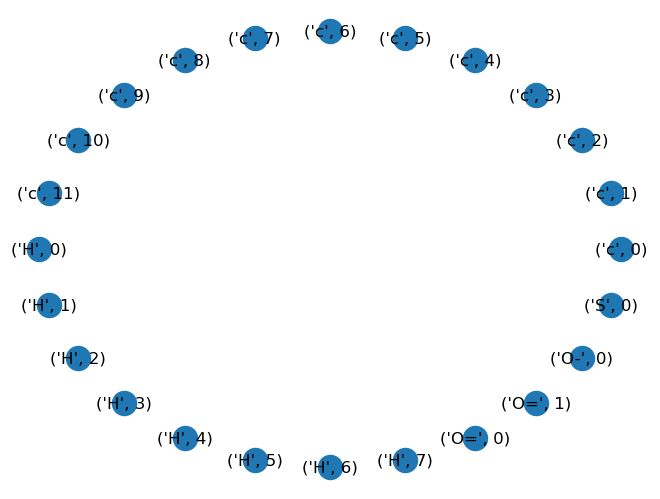

In [3]:
# insert atoms
molprim = Primitive(label='phenylene sulfone middle monomer')
elem_counts : dict[str, int] = { # analogous to a Hill formula
    'c'  : 12,
    'H'  : 8,
    'O=' : 2,
    'O-' : 1,
    'S'  : 1,
}
for label, num_elem in elem_counts.items():
    for _ in range(num_elem):
        molprim.attach_child(prim_elem_map[label].copy())
molprim.visualize_topology()

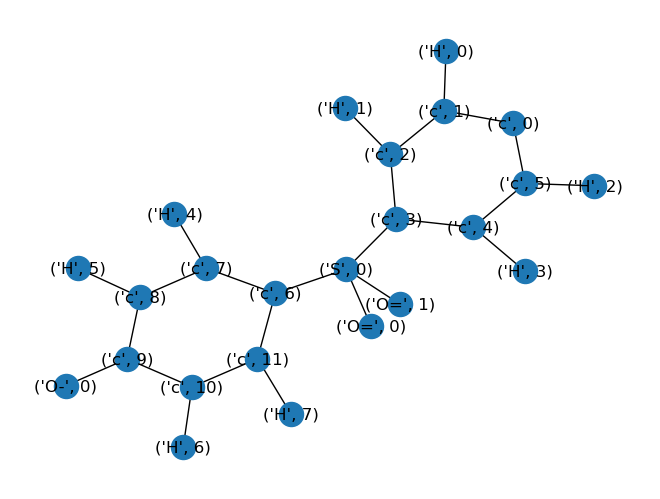

In [4]:
# pair up atoms
arene_1_bonds = [
    (('c', 0), ('arene_c:c', 1) , ('c', 1), ('arene_c:c', 0)),
    (('c', 1), ('arene_wild', 0), ('H', 0), ('arene_c-H', 0)),
    (('c', 1), ('arene_c:c', 1) , ('c', 2), ('arene_c:c', 0)),
    (('c', 2), ('arene_wild', 0), ('H', 1), ('arene_c-H', 0)),
    (('c', 2), ('arene_c:c', 1) , ('c', 3), ('arene_c:c', 0)),
    (('c', 3), ('arene_c:c', 1) , ('c', 4), ('arene_c:c', 0)),
    (('c', 4), ('arene_c:c', 1) , ('c', 5), ('arene_c:c', 0)),
    (('c', 4), ('arene_wild', 0), ('H', 3), ('arene_c-H', 0)),
    (('c', 5), ('arene_c:c', 1) , ('c', 0), ('arene_c:c', 0)),
    (('c', 5), ('arene_wild', 0), ('H', 2), ('arene_c-H', 0)),
]
sulfonyl_bonds = [
    (('S', 0), ('sulfonyl_c-S', 0), ('c', 3), ('arene_wild', 0)),
    (('S', 0), ('sulfonyl_S=O', 0), ('O=', 0), ('sulfonyl_O=S', 0)),
    (('S', 0), ('sulfonyl_c-S', 1), ('c', 6), ('arene_wild', 0)),
    (('S', 0), ('sulfonyl_S=O', 1), ('O=', 1), ('sulfonyl_O=S', 0)),
]
arene_2_bonds = [
    (('c',  6), ('arene_c:c', 1) , ('c', 7) , ('arene_c:c', 0)),
    (('c',  7), ('arene_wild', 0), ('H', 4) , ('arene_c-H', 0)),
    (('c',  7), ('arene_c:c', 1) , ('c', 8) , ('arene_c:c', 0)),
    (('c',  8), ('arene_wild', 0), ('H', 5) , ('arene_c-H', 0)),
    (('c',  8), ('arene_c:c', 1) , ('c', 9) , ('arene_c:c', 0)),
    (('c',  9), ('arene_c:c', 1) , ('c', 10), ('arene_c:c', 0)),
    (('c', 10), ('arene_c:c', 1) , ('c', 11), ('arene_c:c', 0)),
    (('c', 10), ('arene_wild', 0), ('H', 6) , ('arene_c-H', 0)),
    (('c', 11), ('arene_c:c', 1) , ('c', 6) , ('arene_c:c', 0)),
    (('c', 11), ('arene_wild', 0), ('H', 7) , ('arene_c-H', 0)),
]
oxygen_bond = [
    (('O-', 0), ('arene_c-O', 0), ('c', 9), ('arene_wild', 0)),
]

all_bonds = [*arene_1_bonds, *sulfonyl_bonds, *arene_2_bonds, *oxygen_bond]
for bonded_pair in all_bonds:
    molprim.connect_children(*bonded_pair)

molprim.visualize_topology()

Note: what is currently drawn is not the coordinates of the molecule, but just a visually easy-to-parse embedding of its topology graph